In [3]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from math import sqrt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from helper import series_to_supervised
from model.cnn import cnn_4layer
from model.mlp import mlp_layer

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
# import random

# random.seed(10)
# print(random.random())

In [6]:
dataset = pd.read_csv('../../data/energy_weather.csv', index_col=0)
# https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather

dataset.fillna(0, inplace=True)
data = dataset
data

,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,pressure_Bilbao,...,wind_deg_Bilbao,clouds_all_Bilbao,gen_hyd_river,wind_deg_Seville,wind_speed_Barcelona,wind_speed_Valencia,wind_speed_Bilbao,gen_wind,wind_speed_Madrid,gen_hyd_pump
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,64.92,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,...,229.0,0.0,1009.0,21.0,7.0,1.0,0.0,5890.0,1.0,920.0
2015-01-01 01:00:00+00:00,64.48,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,...,224.0,0.0,973.0,27.0,7.0,0.0,1.0,5461.0,1.0,1164.0
2015-01-01 02:00:00+00:00,59.32,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,...,225.0,0.0,949.0,27.0,7.0,0.0,1.0,5238.0,1.0,1503.0
2015-01-01 03:00:00+00:00,56.04,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,...,221.0,0.0,953.0,27.0,7.0,0.0,1.0,4935.0,1.0,1826.0
2015-01-01 04:00:00+00:00,53.63,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,...,224.0,0.0,952.0,57.0,5.0,2.0,1.0,4618.0,0.0,2109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,77.02,68.85,2628.0,7634.0,30653.0,0.0,178.0,95.0,1027.0,1033.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
2018-12-31 19:00:00+00:00,76.16,68.40,2566.0,7241.0,29735.0,0.0,174.0,95.0,1027.0,1034.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
2018-12-31 20:00:00+00:00,74.30,66.88,2422.0,7025.0,28071.0,0.0,168.0,94.0,1028.0,1034.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0


In [7]:
data.columns

Index(['price', 'price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump'],
      dtype='object')

In [8]:
# plt.hist(data['pollution'], bins=20)

### Preprocess

In [9]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (34980, 2184)


In [10]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (24486, 1872) (24486, 12) (5247, 1872) (5247, 12) (5247, 1872) (5247, 12)


In [11]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (24486, 72, 26) (24486, 12) (5247, 72, 26) (5247, 12) (5247, 72, 26) (5247, 12)


### PM threshold

In [12]:
train_X_pm = train_X[:, 0, feature_idx]
print(train_X_pm.shape)

val_X_pm = val_X[:, 0, feature_idx]
print(val_X_pm.shape)

test_X_pm = test_X[:, 0, feature_idx]
print(test_X_pm.shape)

(24486,)
(5247,)
(5247,)


In [13]:
percentile = 95

merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))

percentile_pm = np.percentile(merged_array, percentile)

print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)

95th Percentile of Daily Rain: 0.7037105569454176


### train_X_filter

In [14]:
train_X_extreme = train_X[train_X_pm > percentile_pm]
print(train_X_extreme.shape)

train_y_extreme = train_y[train_X_pm > percentile_pm]
print(train_y_extreme.shape)

(696, 72, 26)
(696, 12)


In [15]:
train_X_normal = train_X[train_X_pm <= percentile_pm]
print(train_X_normal.shape)

train_y_normal = train_y[train_X_pm <= percentile_pm]
print(train_y_normal.shape)

(23790, 72, 26)
(23790, 12)


### val_X_filter

In [16]:
val_X_extreme = val_X[val_X_pm > percentile_pm]
print(val_X_extreme.shape)

val_y_extreme = val_y[val_X_pm > percentile_pm]
print(val_y_extreme.shape)

(55, 72, 26)
(55, 12)


In [17]:
val_X_normal = val_X[val_X_pm <= percentile_pm]
print(val_X_normal.shape)

val_y_normal = val_y[val_X_pm <= percentile_pm]
print(val_y_normal.shape)

(5192, 72, 26)
(5192, 12)


### test_X_filter

In [18]:
test_X_extreme = test_X[test_X_pm > percentile_pm]
print(test_X_extreme.shape)

test_y_extreme = test_y[test_X_pm > percentile_pm]
print(test_y_extreme.shape)

(998, 72, 26)
(998, 12)


In [19]:
test_X_normal = test_X[test_X_pm <= percentile_pm]
print(test_X_normal.shape)

test_y_normal = test_y[test_X_pm <= percentile_pm]
print(test_y_normal.shape)

(4249, 72, 26)
(4249, 12)


In [20]:
# Load your dataset
D_f, y_f = train_X, train_y                # Training data (includes both X_rain and X_norm)
D_g, y_g = val_X_extreme, val_y_extreme    # Validation data
# D_g, y_g = np.concatenate((val_X_extreme, test_X_extreme)), np.concatenate((val_y_extreme, test_y_extreme))    # Validation data

In [21]:
D_f.shape

(24486, 72, 26)

### Model

In [22]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0  # 0.1
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [24]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )

In [25]:
# Define the forward function for the model
def forward(model, X, y, weights):
    predictions = model(X, training=True)
    loss = tf.reduce_mean(tf.losses.mean_squared_error(y, predictions) * weights)
    return loss, predictions


def backward(loss):
    # Compute gradients of loss with respect to model parameters
    gradients = tf.gradients(loss, model.trainable_variables)
    return gradients



# Assuming model, D_f, y_f, example_weights, etc. are defined

# Define the loss function
def calculate_loss(model, X, y, weights):
    predictions = model(X)
    individual_losses = tf.losses.mean_squared_error(y, predictions)  # This gives a loss per sample
    weighted_losses = individual_losses * weights
    return tf.reduce_mean(weighted_losses), individual_losses

In [37]:
# # Define the optimizer for the primary model
# optimizer = Adam(learning_rate=0.01)

# Initialize the example weights wi with ones
# example_weights = tf.ones(shape=(len(D_f)))

sample_weights_IPF = np.load('sample_weights_price_IPF.npy')
example_weights = tf.convert_to_tensor(sample_weights_IPF, dtype=tf.float32)


# Batch size
batch_size = 64

In [38]:
# Training loop
for t in range(100):  # Number of iterations
    # Shuffle the training data and example weights at the beginning of each epoch
    indices = np.arange(len(D_f))
    #np.random.shuffle(indices)
    D_f_shuffled = tf.gather(D_f, indices)
    y_f_shuffled = tf.gather(y_f, indices)

    
    example_weights_shuffled = tf.gather(example_weights, indices)
    #print("example_weights_shuffled:", example_weights_shuffled.numpy()[:10])
    
    
    # Convert example_weights_shuffled back to a tf.Variable if it's not one after tf.gather
    example_weights_shuffled = tf.Variable(example_weights_shuffled)
    #print("example_weights_shuffled:", example_weights_shuffled.numpy()[:10])

    
    # Iterate over mini-batches
    for i in range(0, len(D_f), batch_size):
        # Slice the mini-batch
        X_batch = D_f_shuffled[i:i+batch_size]
        y_batch = y_f_shuffled[i:i+batch_size]
        w_batch = example_weights_shuffled[i:i+batch_size]

        # Forward pass on the training data with example weights
        with tf.GradientTape() as tape:
            train_loss_f, _ = forward(model, X_batch, y_batch, w_batch)
        gradients_f = tape.gradient(train_loss_f, model.trainable_variables)

        # Apply gradients to update the model parameters
        model.optimizer.apply_gradients(zip(gradients_f, model.trainable_variables))

        
    # After processing all mini-batches, evaluate on validation set
    val_loss_g, val_predictions_g = forward(model, D_g, y_g, tf.ones(shape=(len(D_g), 1)))

    
    # Meta-learning step: Compute the influence of training example weights on validation loss
    with tf.GradientTape() as tape:
        # Re-compute training loss for shuffled data with current model parameters and example weights
        tape.watch(example_weights_shuffled)
        train_loss_f, _ = forward(model, D_f_shuffled, y_f_shuffled, example_weights_shuffled)

        
    # Now compute gradients of this loss w.r.t. the example weights
    example_weight_gradients = tape.gradient(train_loss_f, example_weights_shuffled)
    
    
    # Adjust example weights based on gradients: This is a simplistic approach; actual update rule may differ
    example_weight_updates = -0.001 * example_weight_gradients
    
    
    # Apply updates to the example weights
    example_weights_shuffled.assign_add(example_weight_updates)
    
    # Ensure example_weights remain non-negative and re-normalize
    example_weights_shuffled.assign(tf.maximum(example_weights_shuffled, 0))
    example_weights_shuffled.assign(example_weights_shuffled / tf.reduce_sum(example_weights_shuffled))
    
    
    # Update the original example weights
    indices_matrix = tf.reshape(indices, (len(indices), 1)) 
    example_weights = tf.tensor_scatter_nd_update(example_weights, indices_matrix, example_weights_shuffled)
    #print("example_weights:", example_weights[:3])
    

    
    # Log the progress
    print(f'Epoch {t+1}: Training Loss = {train_loss_f.numpy():.6f}, Validation Loss = {val_loss_g.numpy():.6f} \n')

Epoch 1: Training Loss = 0.000000, Validation Loss = 0.010242 

Epoch 2: Training Loss = 0.000000, Validation Loss = 0.010414 

Epoch 3: Training Loss = 0.000000, Validation Loss = 0.010424 

Epoch 4: Training Loss = 0.000000, Validation Loss = 0.010430 

Epoch 5: Training Loss = 0.000000, Validation Loss = 0.010437 

Epoch 6: Training Loss = 0.000000, Validation Loss = 0.010441 

Epoch 7: Training Loss = 0.000000, Validation Loss = 0.010448 

Epoch 8: Training Loss = 0.000000, Validation Loss = 0.010458 

Epoch 9: Training Loss = 0.000000, Validation Loss = 0.010467 

Epoch 10: Training Loss = 0.000000, Validation Loss = 0.010478 

Epoch 11: Training Loss = 0.000000, Validation Loss = 0.010485 

Epoch 12: Training Loss = 0.000000, Validation Loss = 0.010491 

Epoch 13: Training Loss = 0.000000, Validation Loss = 0.010499 

Epoch 14: Training Loss = 0.000000, Validation Loss = 0.010504 

Epoch 15: Training Loss = 0.000000, Validation Loss = 0.010507 

Epoch 16: Training Loss = 0.000000

In [39]:
example_weights = example_weights.numpy()
# example_weights /= np.max(example_weights) 
# example_weights = (example_weights - np.min(example_weights)) / (np.max(example_weights) - np.min(example_weights)) + 0.1

In [44]:
example_weights /= np.max(example_weights) 

(array([1.9942e+04, 2.6140e+03, 1.2390e+03, 2.7200e+02, 1.6500e+02,
        0.0000e+00, 0.0000e+00, 1.5100e+02, 5.4000e+01, 0.0000e+00,
        3.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2000e+01]),
 array([0.05353577, 0.10085899, 0.1481822 , 0.19550541, 0.24282862,
        0.29015183, 0.33747503, 0.38479826, 0.43212146, 0.47944468,
        0.52676791, 0.57409108, 0.6214143 , 0.66873753, 0.71606076,
        0.76338392, 0.81070715, 0.85803038, 0.90535361, 0.95267677,
        1.        ]),
 <BarContainer object of 20 artists>)

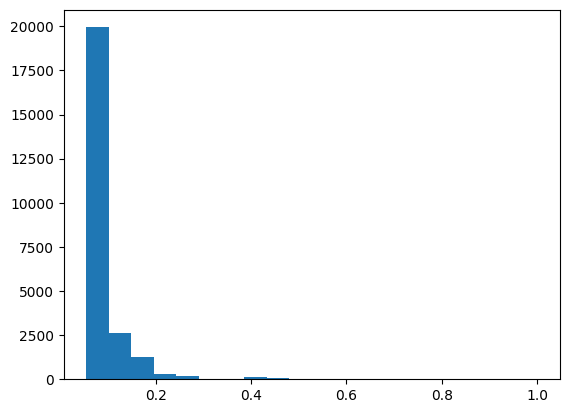

In [45]:
plt.hist(example_weights, bins=20)

In [47]:
model.compile(optimizer='adam',
#               loss=[custom_weight_loss],
              loss='mse',
              metrics=['mae']
             )

es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models/price_all_weighted_META.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True,
#                      custom_objects={'custom_weight_loss':custom_weight_loss}
                    )


model.fit(train_X, train_y,
          validation_data=(val_X, val_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc],
          sample_weight=example_weights
         )

Epoch 1/1000

Epoch 1: val_mae improved from inf to 0.06884, saving model to ../../saved_models/energy_all_weighted_META.h5
48/48 - 1s - loss: 1.0215e-04 - mae: 0.0273 - val_loss: 0.0084 - val_mae: 0.0688 - 999ms/epoch - 21ms/step
Epoch 2/1000

Epoch 2: val_mae did not improve from 0.06884
48/48 - 0s - loss: 5.2725e-05 - mae: 0.0203 - val_loss: 0.0086 - val_mae: 0.0691 - 304ms/epoch - 6ms/step
Epoch 3/1000

Epoch 3: val_mae did not improve from 0.06884
48/48 - 0s - loss: 4.9162e-05 - mae: 0.0196 - val_loss: 0.0086 - val_mae: 0.0690 - 306ms/epoch - 6ms/step
Epoch 4/1000

Epoch 4: val_mae did not improve from 0.06884
48/48 - 0s - loss: 4.7300e-05 - mae: 0.0192 - val_loss: 0.0086 - val_mae: 0.0691 - 307ms/epoch - 6ms/step
Epoch 5/1000

Epoch 5: val_mae did not improve from 0.06884
48/48 - 0s - loss: 4.5574e-05 - mae: 0.0189 - val_loss: 0.0086 - val_mae: 0.0698 - 301ms/epoch - 6ms/step
Epoch 6/1000

Epoch 6: val_mae did not improve from 0.06884
48/48 - 0s - loss: 4.3809e-05 - mae: 0.0185 -

KeyboardInterrupt: 